In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle, os

2024-01-04 03:17:01.690139: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
pdf_base_dir = utils.make_dir('pdfs')
pdf_dir = utils.make_dir(f'{pdf_base_dir}/necessity_and_sufficiency/')

# Necessity

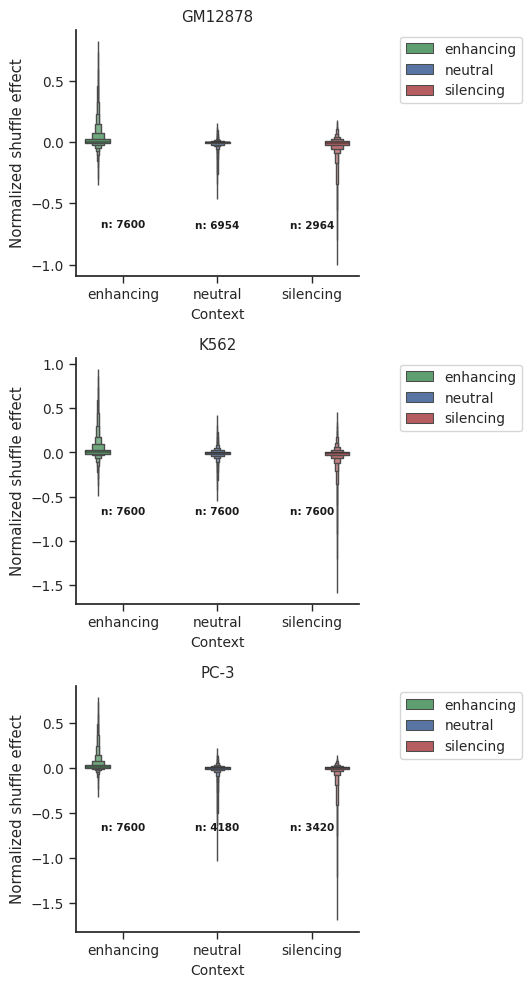

In [6]:
nec_result_summary = pd.read_csv('../results/summary_csvs/enformer/necessity_test.csv')
my_pal = {"enhancing": "g", "neutral": "b", "silencing":"r"}
sns.set(font_scale = .9)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

fig, axes = plt.subplots(3, 1, figsize=[7, 10])

for j, (cell, df) in enumerate(nec_result_summary.groupby('cell_line')):
    ax = axes[j]
    sns.boxenplot(x='context', y='Normalized shuffle effect', data=df, 
                  showfliers=False,
                  hue='context', ax=ax,
                  palette = my_pal)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Context', fontsize=10)
    ax.legend(bbox_to_anchor=[1.6, 1])

    # add number of observations in each box
    medians = df.groupby(['context'])['Normalized shuffle effect'].median().values
    nobs = df['context'].value_counts().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]

    # Add it to the plot
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick],
                medians[tick] - .7,
                nobs[tick],
                horizontalalignment='center',
                size='x-small',
                color='k',
                weight='semibold')
    ax.set_title(cell)
plt.tight_layout()

fig.savefig(f'{pdf_dir}/enformer_necessity_test.pdf')
    

In [31]:
selected_cres = pd.read_csv('../results/summary_csvs/enformer/necessary_CREs.csv')

In [32]:
selected_cres.groupby(['cell_line', 'tile class', 'context']).count()

Unnamed: 0  Normalized shuffle effect  seq_id   
cell_line tile class context                                                    
GM12878   Enhancer   enhancing         147                        147     147  \
          Silencer   silencing          52                         52      52   
K562      Enhancer   enhancing         238                        238     238   
          Silencer   silencing         143                        143     143   
PC-3      Enhancer   enhancing         168                        168     168   
          Silencer   silencing          69                         69      69   

                                tile_start  tile_end  
cell_line tile class context                          
GM12878   Enhancer   enhancing         147       147  
          Silencer   silencing          52        52  
K562      Enhancer   enhancing         238       238  
          Silencer   silencing         143       143  
PC-3      Enhancer   enhancing         168       168  
          Silencer   silencing          69        69

# Sufficiency

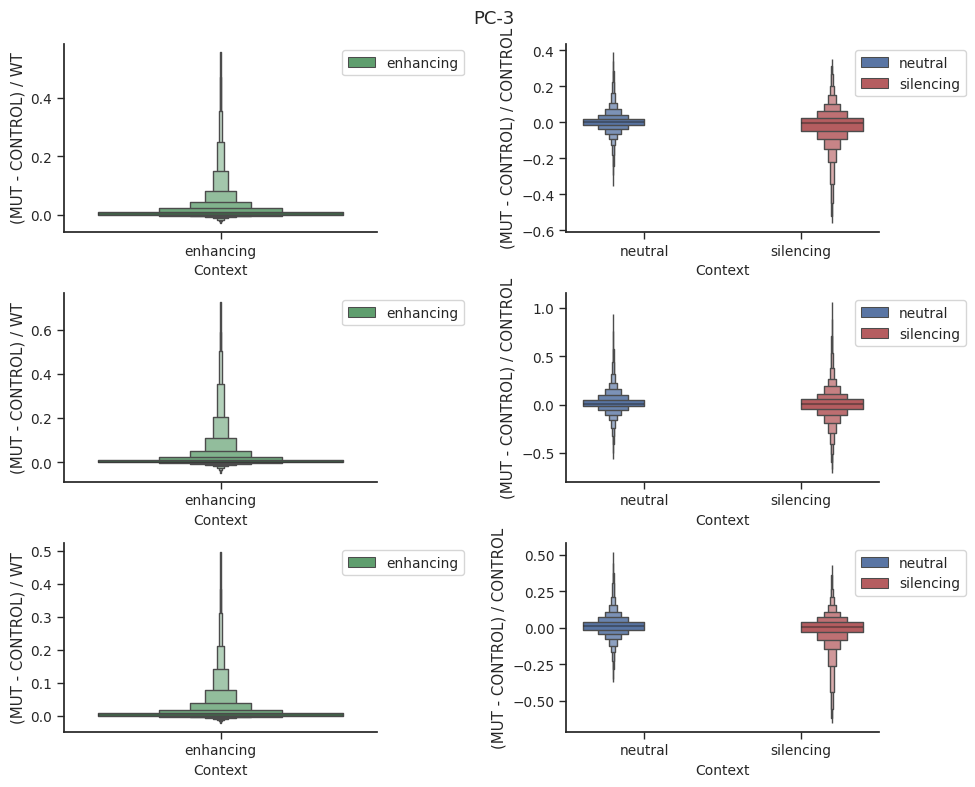

In [43]:
suf_result_summary = pd.read_csv('../results/summary_csvs/enformer/sufficiency_test.csv')
my_pal = {"enhancing": "g", "neutral": "b", "silencing":"r"}
sns.set(font_scale = .9)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

fig, axes = plt.subplots(3, 2, figsize=[10, 8])

for c, (cell, df) in enumerate(suf_result_summary.groupby('cell_line')):
    enh_cont = df[df['context'] == 'enhancing']
    others = df[df['context'] != 'enhancing']
    for p, (df_cont, y) in enumerate([[enh_cont, '(MUT - CONTROL) / WT'],
                                     [others, '(MUT - CONTROL) / CONTROL']]):
        ax = axes[c, p]
        sns.boxenplot(x='context', y=y, data=df_cont, 
                      showfliers=False,
                      hue='context',
                      ax=ax,
                      palette = my_pal)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel('Context', fontsize=10)
        
        ax.legend(bbox_to_anchor=[1.3,1])
    plt.suptitle(cell)

plt.tight_layout()
fig.savefig(f'{pdf_dir}/enformer_sufficiency_test.pdf')


# threshold CREs for distance test

In [39]:
selected_cres = pd.read_csv('../results/summary_csvs/enformer/sufficient_CREs.csv')
selected_cres.groupby(['cell_line', 'tile class', 'context']).count()

Unnamed: 0  (MUT - CONTROL) / WT   
cell_line tile class context                                       
GM12878   Enhancer   enhancing          41                    41  \
          Silencer   silencing          57                    57   
K562      Enhancer   enhancing          74                    74   
          Silencer   silencing         222                   222   
PC-3      Enhancer   enhancing          35                    35   
          Silencer   silencing          97                    97   

                                (MUT - CONTROL) / CONTROL  seq_id  control   
cell_line tile class context                                                 
GM12878   Enhancer   enhancing                         41      41       41  \
          Silencer   silencing                         57      57       57   
K562      Enhancer   enhancing                         74      74       74   
          Silencer   silencing                        222     222      222   
PC-3      Enhancer   enhancing                         35      35       35   
          Silencer   silencing                         97      97       97   

                                 wt  mut  tile_start  tile_end   
cell_line tile class context                                     
GM12878   Enhancer   enhancing   41   41          41        41  \
          Silencer   silencing   57   57          57        57   
K562      Enhancer   enhancing   74   74          74        74   
          Silencer   silencing  222  222         222       222   
PC-3      Enhancer   enhancing   35   35          35        35   
          Silencer   silencing   97   97          97        97   

                                Normalized CRE effect  
cell_line tile class context                           
GM12878   Enhancer   enhancing                     41  
          Silencer   silencing                     57  
K562      Enhancer   enhancing                     74  
          Silencer   silencing                    222  
PC-3      Enhancer   enhancing                     35  
          Silencer   silencing                     97

In [51]:
nec_result_summary

,Unnamed: 0,Normalized shuffle effect,seq_id,tile_start,tile_end,context,cell_line
0,0,0.000554,ALDH3B1_chr11_68010326_+,804,5804,enhancing,PC-3
1,1,-0.001873,ALDH3B1_chr11_68010326_+,5804,10804,enhancing,PC-3
2,2,-0.007596,ALDH3B1_chr11_68010326_+,10804,15804,enhancing,PC-3
3,3,-0.009502,ALDH3B1_chr11_68010326_+,15804,20804,enhancing,PC-3
4,4,0.001267,ALDH3B1_chr11_68010326_+,20804,25804,enhancing,PC-3
...,...,...,...,...,...,...,...
55513,33,-0.002138,ACSL6_chr5_131994579_-,170804,175804,silencing,K562
55514,34,-0.014060,ACSL6_chr5_131994579_-,175804,180804,silencing,K562
55515,35,0.001644,ACSL6_chr5_131994579_-,180804,185804,silencing,K562
55516,36,-0.109519,ACSL6_chr5_131994579_-,185804,190804,silencing,K562


Text(0.5, 1.0, 'enhancing context')

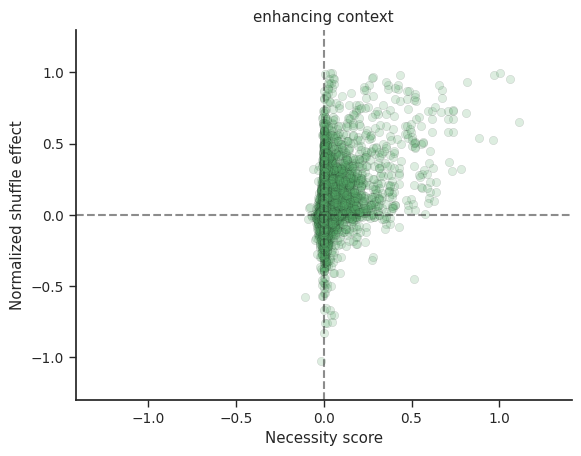

In [82]:
merged_df = nec_result_summary[nec_result_summary['context'] == 'enhancing'].merge(suf_result_summary[suf_result_summary['context'] == 'enhancing'], on=['seq_id', 'tile_start'])
x_max = merged_df['(MUT - CONTROL) / WT'].max()+0.3
y_max = merged_df['Normalized shuffle effect'].max()+0.3
ax=sns.scatterplot(data=merged_df, x='(MUT - CONTROL) / WT', y='Normalized shuffle effect', color='g', alpha=0.2, linewidth=0.3, edgecolor='k')
plt.xlim(-x_max, x_max)
plt.ylim(-y_max, y_max)
plt.vlines(0, -y_max, y_max, linestyle='--', color='k', alpha=0.5)
plt.hlines(0, -x_max, x_max, linestyle='--', color='k', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Sufficiency score')
ax.set_xlabel('Necessity score')
plt.title(f'enhancing context')

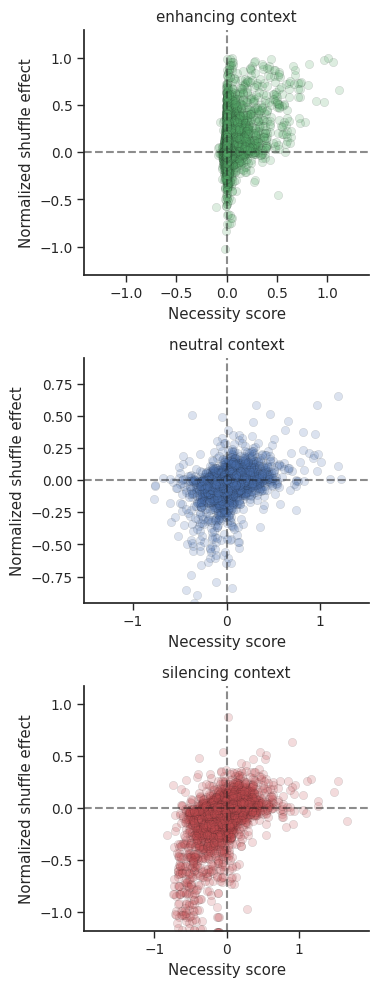

In [91]:
colors = ['g', 'b', 'r']
y = 'Normalized shuffle effect'
fig, axes = plt.subplots(3, 1, figsize=[4, 10])
for i, c in enumerate(['enhancing', 'neutral', 'silencing']):
    ax = axes[i]
    if c == 'enhancing':
        x = '(MUT - CONTROL) / WT'
    else:
        x = '(MUT - CONTROL) / CONTROL'
        
        
    merged_df = nec_result_summary[nec_result_summary['context'] == c].merge(suf_result_summary[suf_result_summary['context'] == c], on=['seq_id', 'tile_start'])
    x_max = merged_df[x].max()+0.3
    y_max = merged_df[y].max()+0.3
    sns.scatterplot(data=merged_df, x=x, y=y, color=colors[i], alpha=0.2, linewidth=0.3, edgecolor='k', ax=ax)
    ax.set_xlim(-x_max, x_max)
    ax.set_ylim(-y_max, y_max)
    ax.vlines(0, -y_max, y_max, linestyle='--', color='k', alpha=0.5)
    ax.hlines(0, -x_max, x_max, linestyle='--', color='k', alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Sufficiency score')
    ax.set_xlabel('Necessity score')
    ax.set_title(f'{c} context')
plt.tight_layout()
fig.savefig(f'{pdf_dir}/necessity_vs_sufficiency_scatterplots.pdf')